In [1]:
pip install pywgcna

Note: you may need to restart the kernel to use updated packages.


In [2]:
# python
###############################################################################
# PyWGCNA analysis: 16-sample 2×2 design (Genotype × Treatment)
# Author: Linkan Dash      Date: 6/2/25
###############################################################################

import os
import pandas as pd
from PyWGCNA.geneExp import GeneExp                 # expression container
from PyWGCNA.wgcna     import WGCNA                 # main class
from PyWGCNA.utils     import getGeneList           # optional gene-info helper

In [3]:
###############################################################################
# 0. User paths
###############################################################################
expr_file        = "expression_TPM.csv"           # genes rows, samples cols
geneinfo_file    = "gene_info.csv"                # optional; can be None
sampleinfo_file  = "sample_info.csv"              # required

species          = "arabidopsis"                       ### <— CHANGED
level            = "gene"
output_dir       = "WGCNA_results"
figtype          = "pdf"

os.makedirs(output_dir, exist_ok=True)

In [4]:
###############################################################################
# 1. Load data
###############################################################################
expr  = pd.read_csv(expr_file, index_col=0)

# Gene annotation ------------------------------------------------------------
if geneinfo_file and os.path.exists(geneinfo_file):
    ginfo = pd.read_csv(geneinfo_file, index_col=0)
else:
    # BioMart dataset for A. thaliana resides on Ensembl Plants
    ginfo = getGeneList(dataset = "athaliana_eg_gene",   ### <— CHANGED
                        server_domain = "http://plants.ensembl.org/biomart")
    # keep only rows present in the expression set
    ginfo = ginfo.set_index("gene_id").loc[expr.index].reset_index()

# Sample annotation ----------------------------------------------------------
sinfo = pd.read_csv(sampleinfo_file, index_col=0)
sinfo = sinfo.loc[expr.columns]                        # enforce same order


In [5]:
###############################################################################
# 2. Wrap in GeneExp
###############################################################################
geneExp = GeneExp(species     = species,
                  level       = level,
                  geneExp     = expr.T,
                  geneInfo    = ginfo,
                  sampleInfo  = sinfo)


In [6]:
###############################################################################
# 3. Create WGCNA object  (parameters tuned for n = 16)
###############################################################################
wgcna = WGCNA(name           = "Ath_32s",
              species        = species,
              level          = level,
              geneExp       = expr.T,
              TPMcutoff      = 1,
              powers         = list(range(1,21)),
              RsquaredCut    = 0.85,
              MeanCut        = 100,
              networkType    = "signed hybrid",
              TOMType        = "signed",
              minModuleSize  = 40,
              MEDissThres    = 0.25,
              save           = True,
              outputPath     = output_dir,
              figureType     = figtype)

Saving data to be True, checking requirements ...


STEP 1/4  Pre-processing …
Pre-processing...
	Detecting genes and samples with too many missing values...
	Done pre-processing..

STEP 2/4  Detecting modules …
Run WGCNA...
pickSoftThreshold: calculating connectivity for given powers...
will use block size  1814
    Power  SFT.R.sq     slope truncated R.sq      mean(k)    median(k)  \
0       1  0.432981  0.474847        0.31164  7197.583043  7757.621859   
1       2  0.044119 -0.159918      -0.006917  3928.711308  4116.915813   
2       3  0.259218 -0.416978       0.340681  2463.539052  2577.862693   
3       4  0.403141 -0.641576       0.553558  1673.235057  1692.538843   
4       5  0.484318 -0.801255       0.676557  1198.261681  1144.967467   
5       6  0.534536 -0.934762       0.742483   891.572452   791.543942   
6       7  0.594596 -1.002508       0.805697   683.067526    561.56052   
7       8   0.63665 -1.062506       0.846323   535.654861   407.735041   
8       9  0.668406 -1.122521       0.871724   428.159751   298.332003 

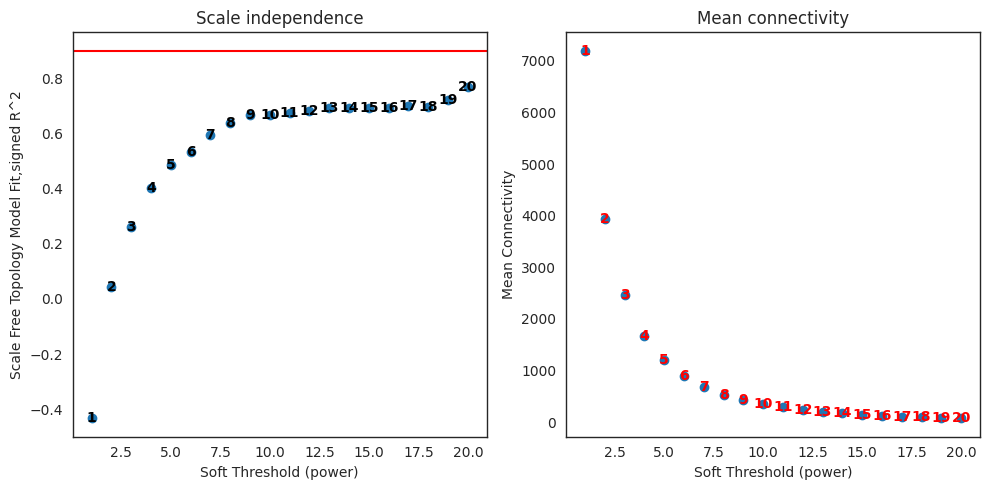

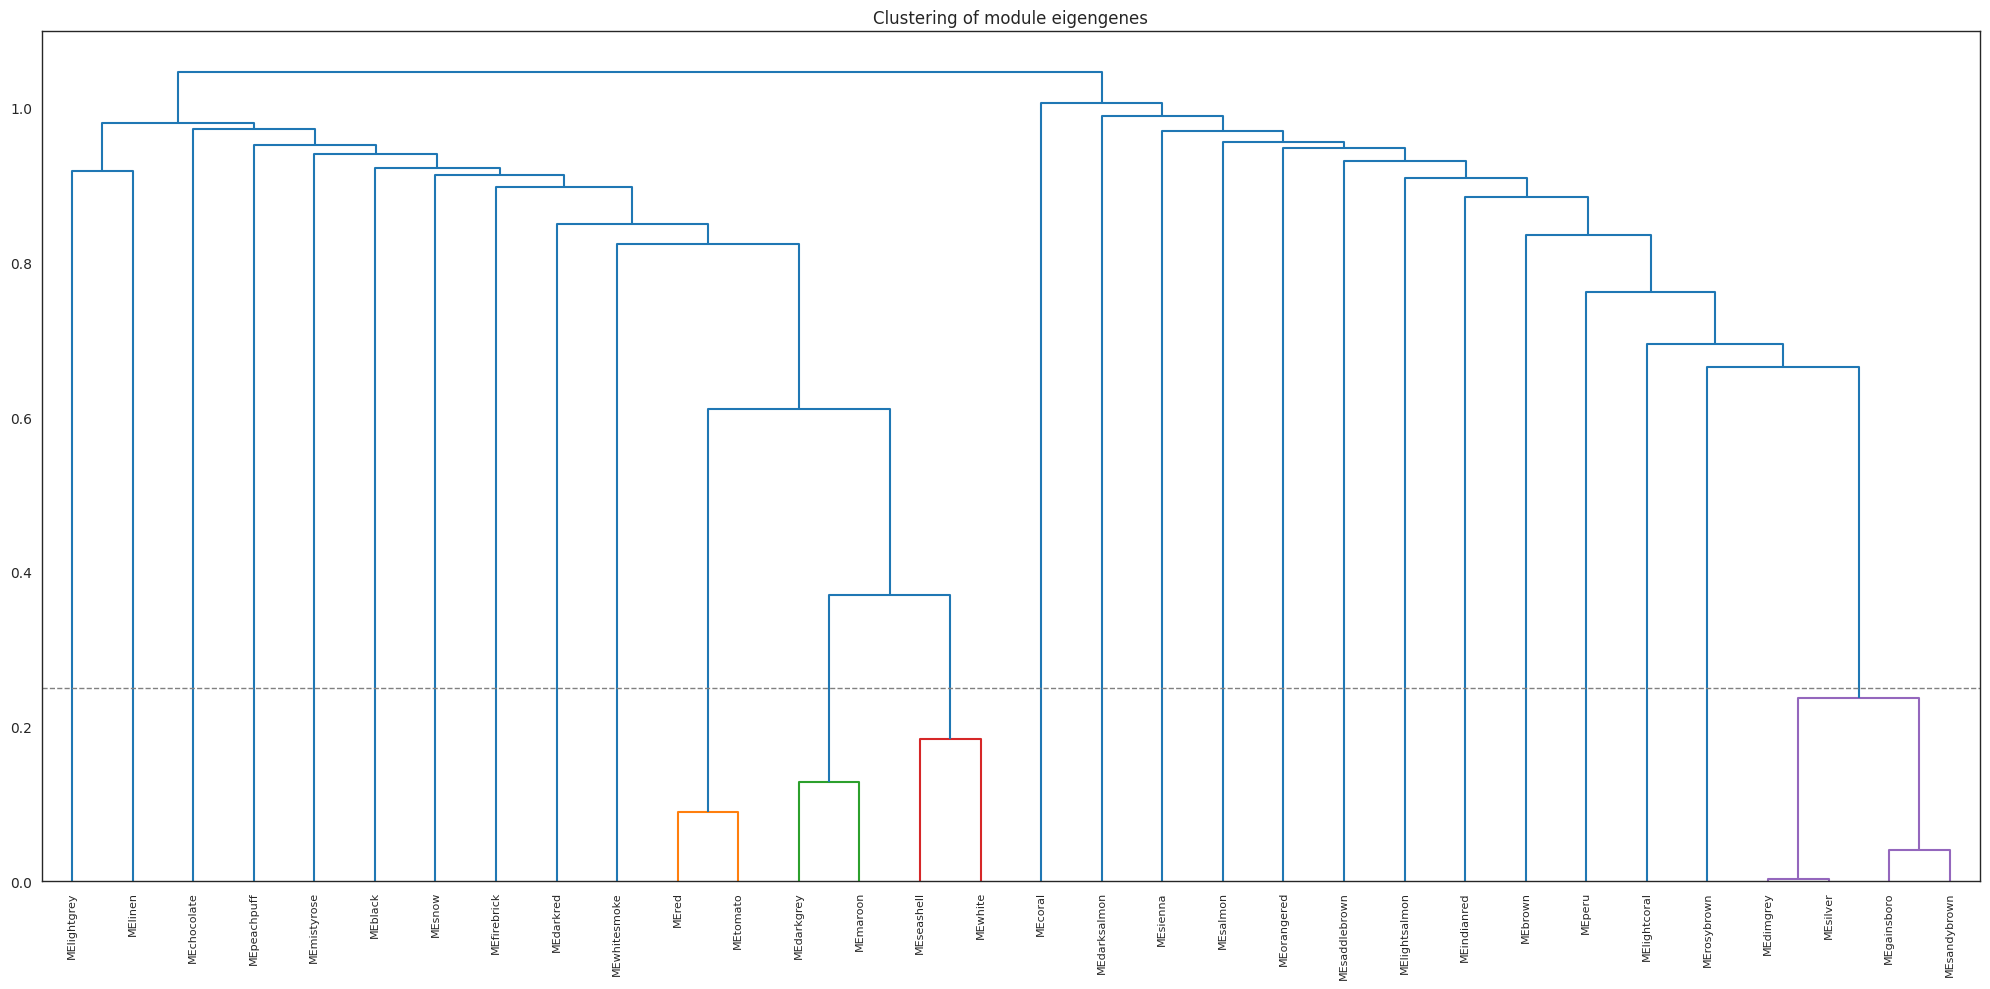

In [7]:
###############################################################################
# 4. Pipeline
###############################################################################
print("STEP 1/4  Pre-processing …")
wgcna.preprocess(show=False)

print("STEP 2/4  Detecting modules …")
wgcna.findModules(kwargs_function={
        'cutreeHybrid': {'deepSplit': 2, 'pamRespectsDendro': False}
})

In [8]:
# python
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
import networkx as nx                         # only for the hub-gene graph

FIGDIR = wgcna.outputPath                     # convenience variable

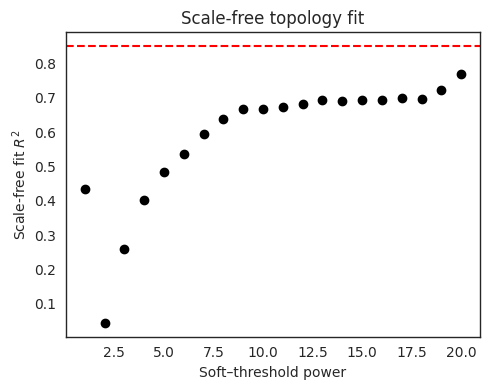

In [9]:
plt.figure(figsize=(5,4))
sft = wgcna.sft                                # dataframe created by pickSoftThreshold
plt.scatter(sft.Power, sft['SFT.R.sq'], c='k')
plt.axhline(0.85, ls='--', c='red')
plt.xlabel('Soft–threshold power')
plt.ylabel('Scale-free fit $R^{2}$')
plt.title('Scale-free topology fit')
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, 'soft_threshold_fit.pdf'))
plt.show()

In [10]:
# after you have created 'wgcna' and already loaded sinfo
wgcna.updateSampleInfo(sampleInfo = sinfo)

In [11]:
# 1) Attach categorical covariates and interactions
wgcna.datExpr.obs["Genotype"]      = sinfo["Genotype"].values          # WT / Mut
wgcna.datExpr.obs["Treatment"]     = sinfo["Treatment"].values         # Unt / Trt
wgcna.datExpr.obs["Time"]          = sinfo["Time"].values              # T0 / T1 / T2 / ...
wgcna.datExpr.obs["GenTxTrt"]      = (
    sinfo["Genotype"] + "_" + sinfo["Treatment"]).values               # WT_Unt etc.
wgcna.datExpr.obs["TrtxTime"]      = (
    sinfo["Treatment"] + "_" + sinfo["Time"]).values 
wgcna.datExpr.obs["GenTxTime"]      = (
    sinfo["Genotype"] + "_" + sinfo["Time"]).values 
wgcna.datExpr.obs["GenTxTrtxTime"]  = (
    sinfo["Genotype"] + "_" + sinfo["Treatment"] + "_" + sinfo["Time"]).values  # WT_Unt_T0 etc.

# 2) Convert to numeric codes (so Pearson r is meaningful)
for col in ["Genotype", "Treatment", "GenTxTrt", "Time", "TrtxTime", "GenTxTime", "GenTxTrtxTime"]:
    wgcna.datExpr.obs[col] = (
        wgcna.datExpr.obs[col].astype("category").cat.codes
    )

In [12]:
print(wgcna.datExpr.obs.head())
# Should now list Genotype, Treatment, GenTxTrt

               Genotype  Treatment  Time Batch  GenTxTrt  TrtxTime  GenTxTime  \
WT_Unt_5d_B1          1          1     1    B1         3         3          3   
WT_Unt_5d_B2          1          1     1    B2         3         3          3   
WT_Unt_5d_B3          1          1     1    B3         3         3          3   
WT_Unt_5d_B4          1          1     1    B4         3         3          3   
Mut_Unt_5d_B1         0          1     1    B1         1         3          1   

               GenTxTrtxTime  
WT_Unt_5d_B1               7  
WT_Unt_5d_B2               7  
WT_Unt_5d_B3               7  
WT_Unt_5d_B4               7  
Mut_Unt_5d_B1              3  


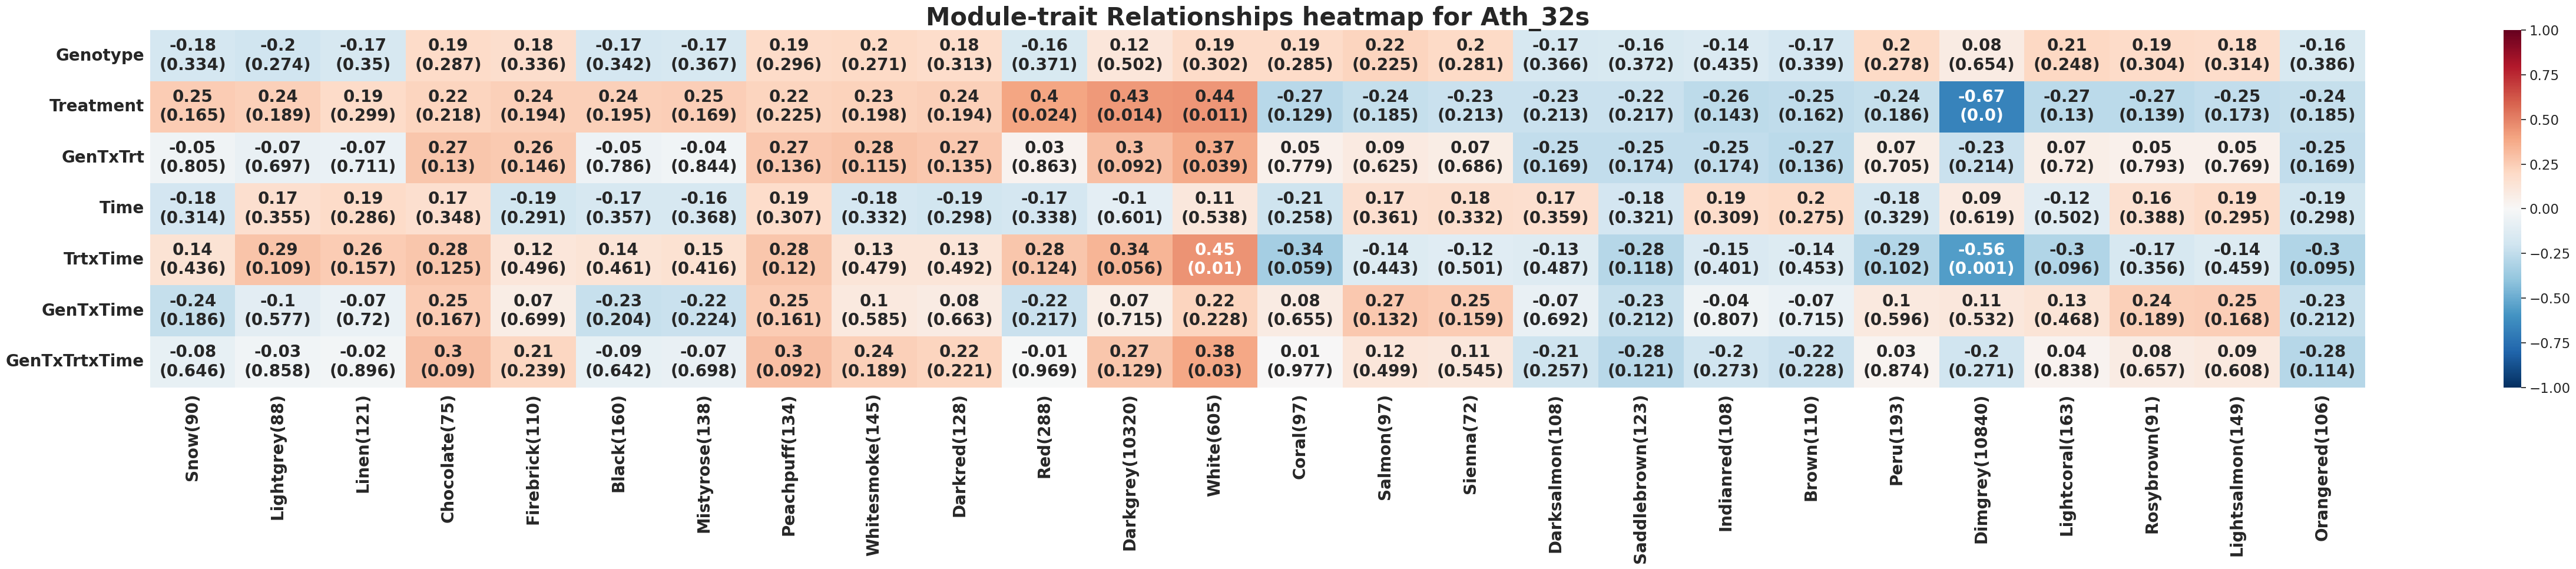

In [13]:
meta_cols = ["Genotype", "Treatment", "GenTxTrt", "Time", "TrtxTime", "GenTxTime", "GenTxTrtxTime"]
wgcna.module_trait_relationships_heatmap(
        meta_cols,
        alternative = "two-sided", figsize=(50, 10))

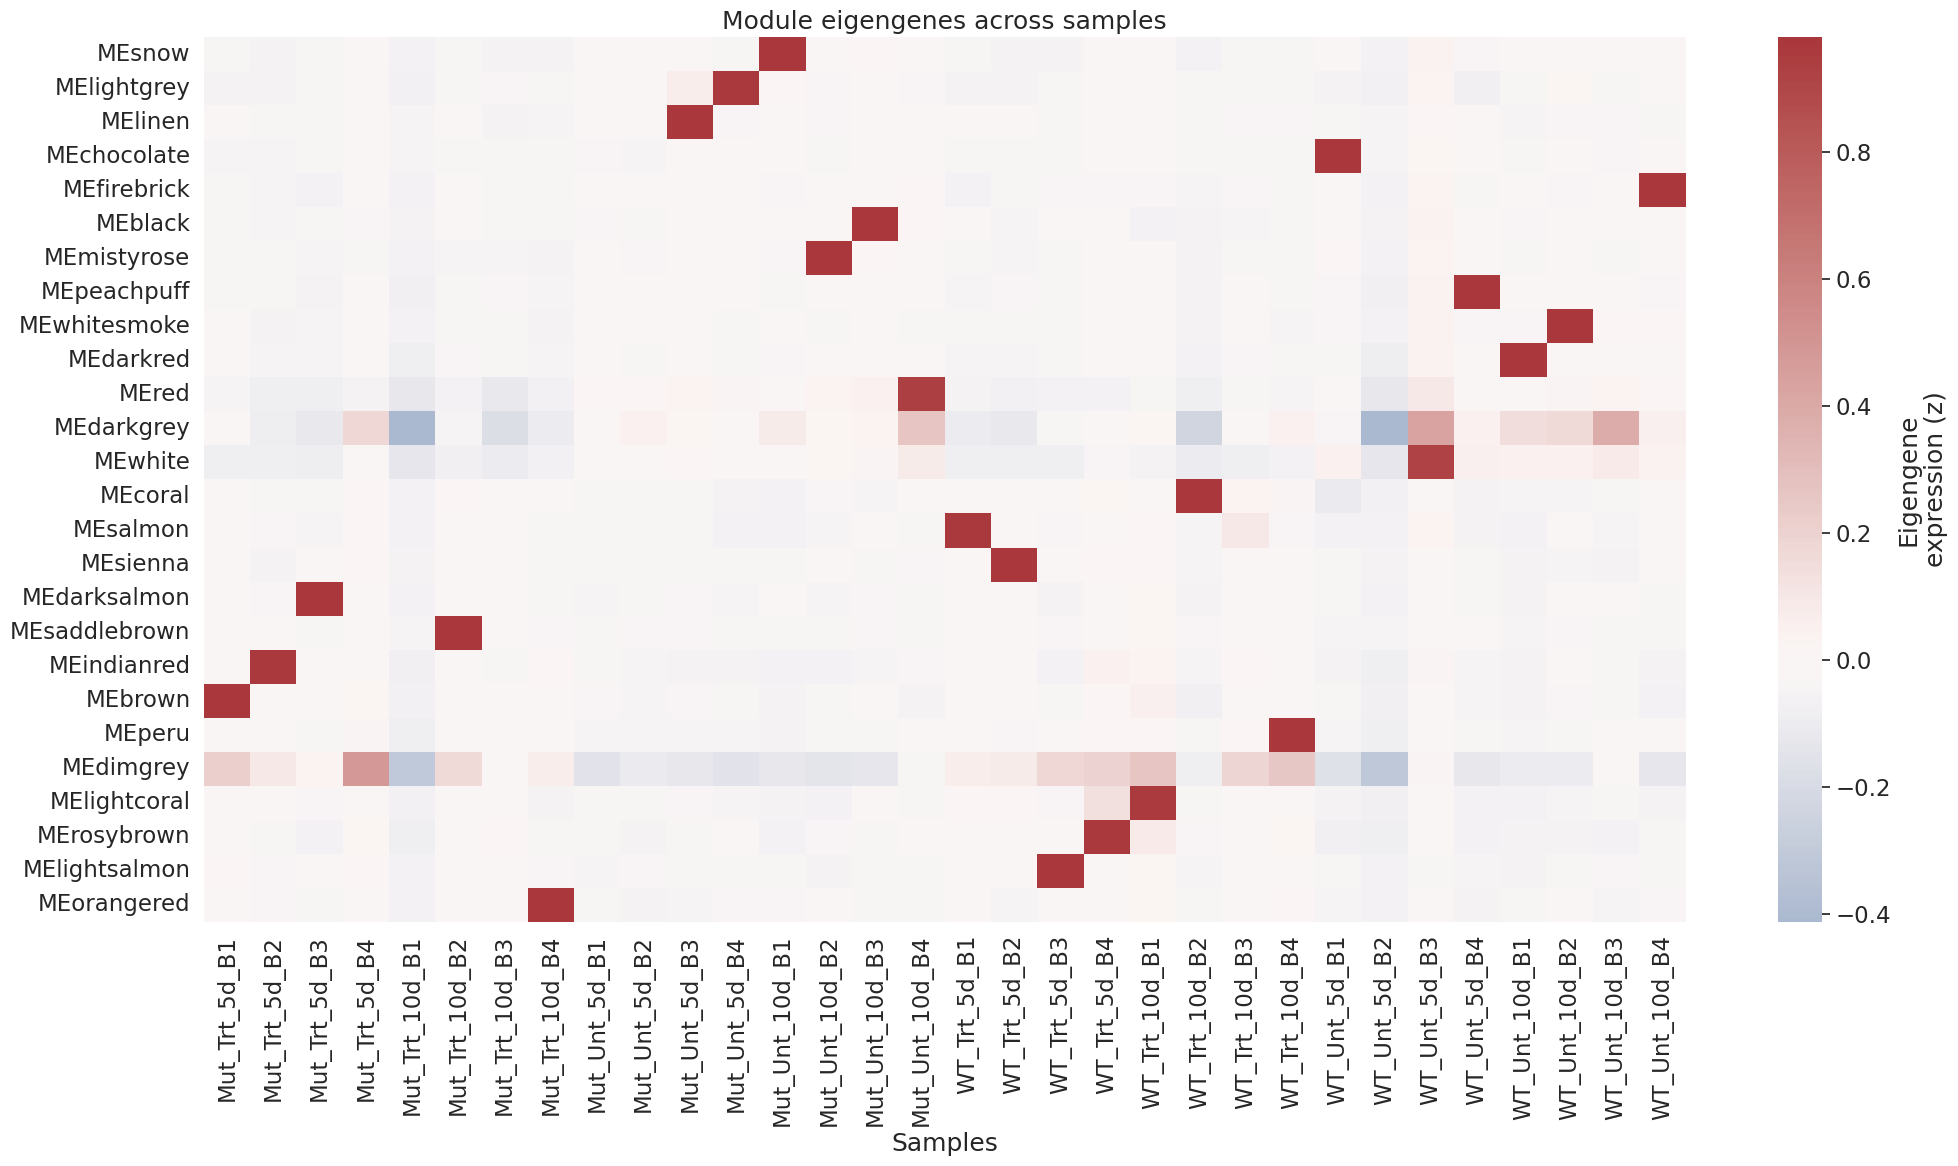

In [14]:
# python
###############################################################################
# 5.  EXTRA VISUALISATIONS  +  EXPORT OF CORE RESULTS
###############################################################################
import os, itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.cluster.hierarchy import dendrogram, linkage


# --------------------------------------------------------------------------- #
#  5A-3  Heat-map of module eigengenes across samples                         #
# --------------------------------------------------------------------------- #
if hasattr(wgcna, "MEs"):
    mes = wgcna.MEs.copy()
else:
    mes = wgcna.moduleEigengenes

# order samples by any trait you like – here by Genotype/Treatment
sample_order = sinfo.sort_values(["Genotype", "Treatment"]).index
mes = mes.loc[sample_order]

plt.figure(figsize=(21, 12))
sns.heatmap(mes.T, cmap="vlag", center=0, cbar_kws=dict(label="Eigengene\nexpression (z)"))
plt.yticks(rotation=0)
plt.title("Module eigengenes across samples")
plt.xlabel("Samples")
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "eigengene_heatmap.pdf"))
plt.show()

In [15]:
import pandas as pd
from pathlib import Path

out_file = Path("WGCNA_results/gene_module_assignment.csv")

# 1.  The colour (module) that each gene belongs to
# -------------------------------------------------
# • wgcna.datExpr.columns  → gene IDs (because datExpr = expr.T)
# • wgcna.moduleColors     → parallel list/array of colour labels
gene2mod = pd.DataFrame(pd.Series(wgcna.datExpr.var.moduleColors,
                      index=wgcna.datExpr.var.index,
                      name="Module"))

# (Optional) add any extra gene annotation you have already loaded
# ----------------------------------------------------------------
gene2mod = gene2mod.merge(ginfo, left_on="gene_id", right_on="gene_id", how="left")

gene2mod.to_csv(out_file, index=False)
print(f"Gene–module table written to → {out_file.resolve()}")

Gene–module table written to → /home/jovyan/pyWGCNA_new/WGCNA_results/gene_module_assignment.csv
